In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd

#import seaborn as sns
#sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-13 08:02:49.312022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 08:02:49.312090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 08:02:49.430795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 08:02:49.710548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

modules loaded


# Data Preprocessing

## Read data and store it in dataframe

In [2]:
train_dir = 'Train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df

,filepaths,labels
0,Train/Non-Fire/dogs79.jpg,Non-Fire
1,Train/Non-Fire/dogs359.jpg,Non-Fire
2,Train/Non-Fire/sunset410.jpg,Non-Fire
3,Train/Non-Fire/cats494.jpg,Non-Fire
4,Train/Non-Fire/dogs207.jpg,Non-Fire
...,...,...
5998,Train/Fire/firenight671.jpg,Fire
5999,Train/Fire/firenight756.jpg,Fire
6000,Train/Fire/fireday575.jpg,Fire
6001,Train/Fire/firenight61.jpg,Fire


In [4]:
valid_dir = 'Vali'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
valid_df

,filepaths,labels
0,Train/Non-Fire/dogs79.jpg,Non-Fire
1,Train/Non-Fire/dogs359.jpg,Non-Fire
2,Train/Non-Fire/sunset410.jpg,Non-Fire
3,Train/Non-Fire/cats494.jpg,Non-Fire
4,Train/Non-Fire/dogs207.jpg,Non-Fire
...,...,...
5998,Train/Fire/firenight671.jpg,Fire
5999,Train/Fire/firenight756.jpg,Fire
6000,Train/Fire/fireday575.jpg,Fire
6001,Train/Fire/firenight61.jpg,Fire


In [6]:
# Generate  test data paths with labels
test_dir = 'Test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
test_df

,filepaths,labels
0,Test/Non-Fire/road_night297.jpg,Non-Fire
1,Test/Non-Fire/sunset306.jpg,Non-Fire
2,Test/Non-Fire/sunset274.jpg,Non-Fire
3,Test/Non-Fire/road_day128.jpg,Non-Fire
4,Test/Non-Fire/sunset300.jpg,Non-Fire
...,...,...
1995,Test/Fire/SynDay420.jpg,Fire
1996,Test/Fire/SynDay476.jpg,Fire
1997,Test/Fire/SynDay246.jpg,Fire
1998,Test/Fire/SynDay305.jpg,Fire


## create image data generator

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 6003 validated image filenames belonging to 2 classes.
Found 6003 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


## Show sample from train data

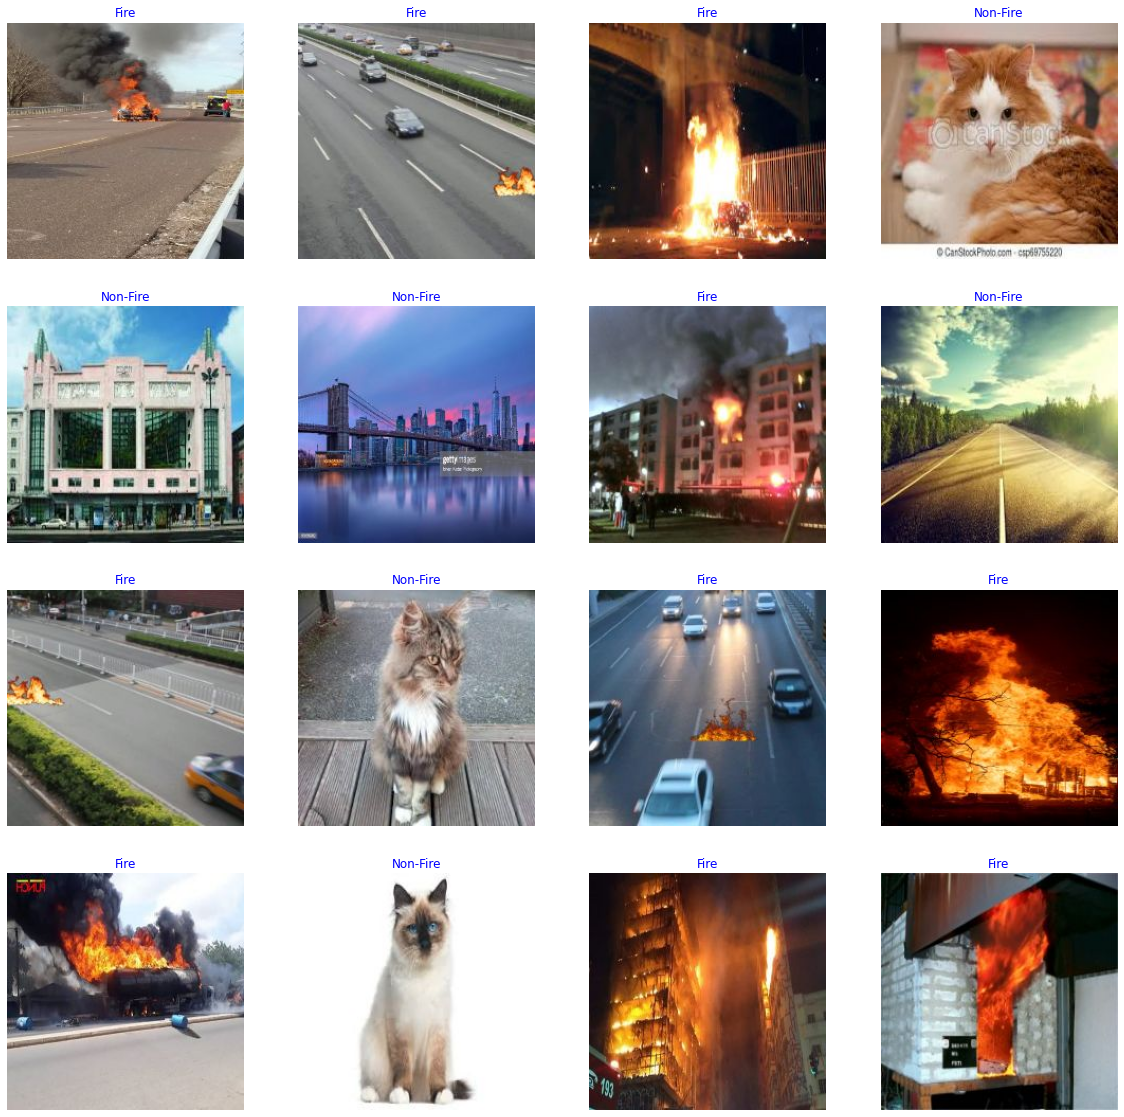

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [10]:
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


In [11]:
print(class_count)

2


In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4136805 (15.78 MB)
Trainable params: 40922

## Train model

In [13]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
376/376 [==============================] - 986s 3s/step - loss: 1.7196 - accuracy: 0.9360 - val_loss: 1.1633 - val_accuracy: 0.9962
Epoch 2/20
376/376 [==============================] - 3676s 10s/step - loss: 0.9455 - accuracy: 0.9725 - val_loss: 0.6935 - val_accuracy: 0.9987
Epoch 3/20
376/376 [==============================] - 972s 3s/step - loss: 0.6014 - accuracy: 0.9830 - val_loss: 0.4442 - val_accuracy: 0.9998
Epoch 4/20
376/376 [==============================] - 974s 3s/step - loss: 0.4111 - accuracy: 0.9885 - val_loss: 0.3139 - val_accuracy: 0.9998
Epoch 5/20
376/376 [==============================] - 974s 3s/step - loss: 0.3038 - accuracy: 0.9918 - val_loss: 0.2390 - val_accuracy: 1.0000
Epoch 6/20
376/376 [==============================] - 974s 3s/step - loss: 0.2390 - accuracy: 0.9922 - val_loss: 0.1805 - val_accuracy: 1.0000
Epoch 7/20
376/376 [==============================] - 974s 3s/step - loss: 0.1883 - accuracy: 0.9947 - val_loss: 0.1421 - val_accuracy: 1.00

# Display model performance

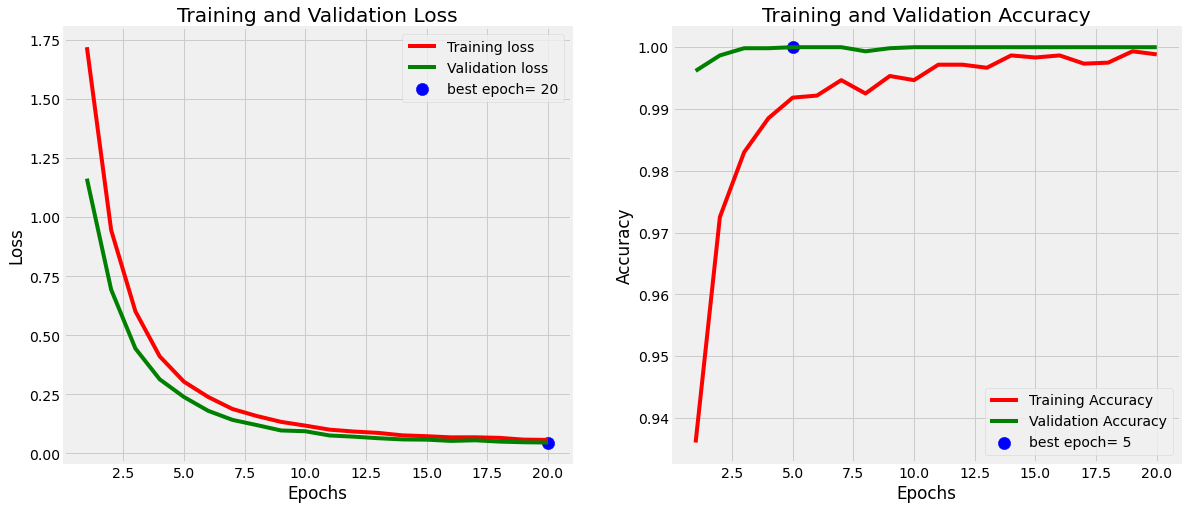

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate Model

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 11s 428ms/step - loss: 0.0769 - accuracy: 0.9925
Train Loss:  0.046354662626981735
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04647452384233475
Validation Accuracy:  1.0
--------------------
Test Loss:  0.07686856389045715
Test Accuracy:  0.9925000071525574


## Get Predictions

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

## Confusion Matrics and Classification Report

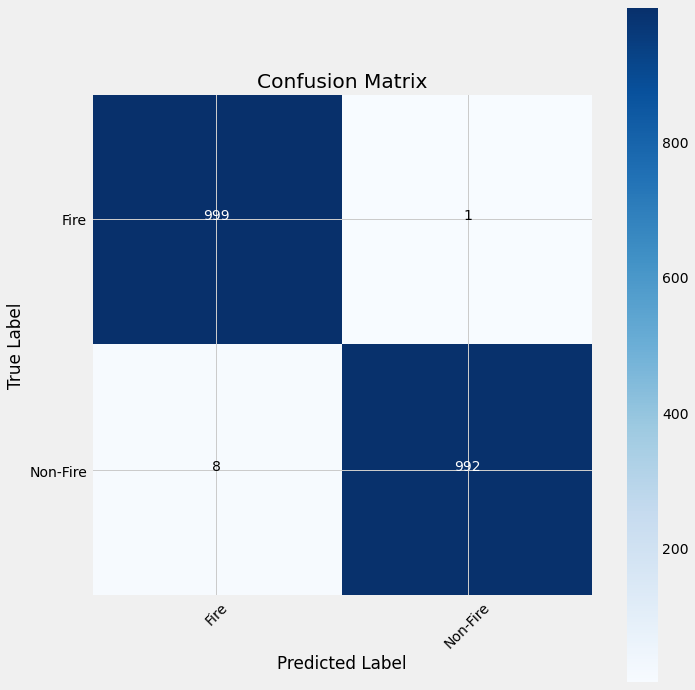

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

        Fire       0.99      1.00      1.00      1000
    Non-Fire       1.00      0.99      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### Save Model

In [21]:
#Save the model
model.save('firemodel.h5')

### Prediction using loaded_model

In [5]:
loaded_model = tf.keras.models.load_model('firemodel.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [12]:
image_path = 'Test/dayroad9.jpg'
image = Image.open(image_path)

classes = ['Fire','Non-fire']

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 42ms/step
Fire
